In [9]:
import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)

import pandas as pd

df = pd.read_excel('Data/Data.xlsx', sheet_name=1, header=None, skiprows=1)

feature_vector = df.iloc[0:1086, :]

additional_features = df.iloc[1087:1099, :]

feature_vector.reset_index(drop=True, inplace=True)
additional_features.reset_index(drop=True, inplace=True)


feature_vector_T = feature_vector.transpose()
additional_features_T = additional_features.transpose()

full_data = pd.concat([feature_vector_T, additional_features_T], axis=1)

full_data.reset_index(drop=True, inplace=True)


df = full_data
df = df.drop(0, axis=0)
df
df.to_csv('output.csv', index=False)


new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

# Reset index for the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()

pd.set_option('display.max_columns', None)  

df = df[~df.isin(['x']).any(axis=1)]

one_hot_encoded_data = pd.get_dummies(df, columns = ['Digester', 'Source', 'Type', 'Waste', 'Biomass']).astype(int)
# print(one_hot_encoded_data)
df_use = one_hot_encoded_data


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Load dataset from DataFrame
def prepare_data(df, target_column):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, df, target_column):
        X, y = prepare_data(df, target_column)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)  # Output is a single continuous value

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.regressor(x).squeeze()

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = mse_loss(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test MSE Loss: {total_loss/len(test_loader):.4f}")

# Sample data (replace with your actual DataFrame)
df = pd.read_csv("Data/New_Data.csv")  # Load your dataset

target_column = "ACE-km"  # Define the target column
train_size = int(0.8 * len(df))
train_df = df_use[:train_size]
test_df = df_use[train_size:]

# Create datasets and data loaders
train_dataset = MicrobialDataset(train_df, target_column)
test_dataset = MicrobialDataset(test_df, target_column)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = train_df.shape[1] - 1  # Number of features
model = TransformerRegressionModel(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, device, epochs=50)
evaluate_model(model, test_loader, device)


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/50], Loss: 249.5402
Epoch [2/50], Loss: 182.2895
Epoch [3/50], Loss: 171.2503
Epoch [4/50], Loss: 131.8796
Epoch [5/50], Loss: 171.4570
Epoch [6/50], Loss: 150.2130
Epoch [7/50], Loss: 164.2311
Epoch [8/50], Loss: 151.8343
Epoch [9/50], Loss: 152.8200
Epoch [10/50], Loss: 176.5534
Epoch [11/50], Loss: 153.3517
Epoch [12/50], Loss: 138.5383
Epoch [13/50], Loss: 155.9194
Epoch [14/50], Loss: 119.9991
Epoch [15/50], Loss: 129.6535
Epoch [16/50], Loss: 126.8164
Epoch [17/50], Loss: 144.9069
Epoch [18/50], Loss: 137.4190
Epoch [19/50], Loss: 127.4180
Epoch [20/50], Loss: 111.3035
Epoch [21/50], Loss: 120.6378
Epoch [22/50], Loss: 136.5822
Epoch [23/50], Loss: 125.1203
Epoch [24/50], Loss: 115.7630
Epoch [25/50], Loss: 128.2270
Epoch [26/50], Loss: 134.8051
Epoch [27/50], Loss: 103.0411
Epoch [28/50], Loss: 123.5336
Epoch [29/50], Loss: 137.4987
Epoch [30/50], Loss: 106.1658
Epoch [31/50], Loss: 108.5831
Epoch [32/50], Loss: 128.9393
Epoch [33/50], Loss: 122.4721
Epoch [34/50], Loss

Fold 1/5
Epoch [1/50], Loss: 223.3166
Epoch [2/50], Loss: 168.5515
Epoch [3/50], Loss: 146.9446
Epoch [4/50], Loss: 139.1348
Epoch [5/50], Loss: 154.4430
Epoch [6/50], Loss: 136.9481
Epoch [7/50], Loss: 174.8510
Epoch [8/50], Loss: 168.1896
Epoch [9/50], Loss: 129.7050


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [10/50], Loss: 118.3592
Epoch [11/50], Loss: 133.1180
Epoch [12/50], Loss: 140.0111
Epoch [13/50], Loss: 133.9958
Epoch [14/50], Loss: 115.3164
Epoch [15/50], Loss: 147.6900
Epoch [16/50], Loss: 112.3510
Epoch [17/50], Loss: 102.3447
Epoch [18/50], Loss: 134.1651
Epoch [19/50], Loss: 128.3810
Epoch [20/50], Loss: 123.0035
Epoch [21/50], Loss: 120.7222
Epoch [22/50], Loss: 103.6551
Epoch [23/50], Loss: 104.6310
Epoch [24/50], Loss: 104.0742
Epoch [25/50], Loss: 95.2166
Epoch [26/50], Loss: 107.0078
Epoch [27/50], Loss: 137.1737
Epoch [28/50], Loss: 131.9939
Epoch [29/50], Loss: 106.4021
Epoch [30/50], Loss: 102.9904
Epoch [31/50], Loss: 98.5846
Epoch [32/50], Loss: 119.4639
Epoch [33/50], Loss: 105.5118
Epoch [34/50], Loss: 125.5372
Epoch [35/50], Loss: 117.8540
Epoch [36/50], Loss: 135.2596
Epoch [37/50], Loss: 104.1995
Epoch [38/50], Loss: 106.3216
Epoch [39/50], Loss: 103.0546
Epoch [40/50], Loss: 99.8127
Epoch [41/50], Loss: 92.0218
Epoch [42/50], Loss: 100.7023
Epoch [43/50],

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/50], Loss: 146.7641
Epoch [3/50], Loss: 188.2028
Epoch [4/50], Loss: 165.3880
Epoch [5/50], Loss: 151.0868
Epoch [6/50], Loss: 157.2357
Epoch [7/50], Loss: 141.8174
Epoch [8/50], Loss: 127.0353
Epoch [9/50], Loss: 124.5090
Epoch [10/50], Loss: 132.1639
Epoch [11/50], Loss: 126.6149
Epoch [12/50], Loss: 146.7889
Epoch [13/50], Loss: 110.4174
Epoch [14/50], Loss: 136.3910
Epoch [15/50], Loss: 142.1597
Epoch [16/50], Loss: 119.3936
Epoch [17/50], Loss: 112.3589
Epoch [18/50], Loss: 123.6389
Epoch [19/50], Loss: 117.4860
Epoch [20/50], Loss: 108.8346
Epoch [21/50], Loss: 138.5260
Epoch [22/50], Loss: 131.0215
Epoch [23/50], Loss: 115.6270
Epoch [24/50], Loss: 107.7471
Epoch [25/50], Loss: 121.3635
Epoch [26/50], Loss: 124.9129
Epoch [27/50], Loss: 104.1268
Epoch [28/50], Loss: 114.6500
Epoch [29/50], Loss: 138.0737
Epoch [30/50], Loss: 109.5515
Epoch [31/50], Loss: 126.7610
Epoch [32/50], Loss: 103.5452
Epoch [33/50], Loss: 128.2684
Epoch [34/50], Loss: 94.8736
Epoch [35/50], Loss

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [7/50], Loss: 190.9743
Epoch [8/50], Loss: 141.2032
Epoch [9/50], Loss: 129.2039
Epoch [10/50], Loss: 147.2991
Epoch [11/50], Loss: 163.6243
Epoch [12/50], Loss: 159.9457
Epoch [13/50], Loss: 124.2693
Epoch [14/50], Loss: 132.2450
Epoch [15/50], Loss: 138.0742
Epoch [16/50], Loss: 124.0898
Epoch [17/50], Loss: 129.2784
Epoch [18/50], Loss: 134.8088
Epoch [19/50], Loss: 121.8713
Epoch [20/50], Loss: 132.8519
Epoch [21/50], Loss: 119.1708
Epoch [22/50], Loss: 139.6085
Epoch [23/50], Loss: 104.1834
Epoch [24/50], Loss: 107.3582
Epoch [25/50], Loss: 128.2121
Epoch [26/50], Loss: 106.8723
Epoch [27/50], Loss: 103.5666
Epoch [28/50], Loss: 122.9052
Epoch [29/50], Loss: 102.5422
Epoch [30/50], Loss: 106.3165
Epoch [31/50], Loss: 126.1768
Epoch [32/50], Loss: 122.0483
Epoch [33/50], Loss: 122.9283
Epoch [34/50], Loss: 109.0548
Epoch [35/50], Loss: 119.4959
Epoch [36/50], Loss: 102.8389
Epoch [37/50], Loss: 104.3295
Epoch [38/50], Loss: 107.3443
Epoch [39/50], Loss: 104.9738
Epoch [40/50]

/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/50], Loss: 129.7911
Epoch [3/50], Loss: 153.4598
Epoch [4/50], Loss: 123.1529
Epoch [5/50], Loss: 146.4892
Epoch [6/50], Loss: 142.0508
Epoch [7/50], Loss: 113.0142
Epoch [8/50], Loss: 104.8473
Epoch [9/50], Loss: 128.9696
Epoch [10/50], Loss: 123.7524
Epoch [11/50], Loss: 96.6258
Epoch [12/50], Loss: 96.7640
Epoch [13/50], Loss: 106.4571
Epoch [14/50], Loss: 109.1326
Epoch [15/50], Loss: 94.2410
Epoch [16/50], Loss: 98.1840
Epoch [17/50], Loss: 103.9245
Epoch [18/50], Loss: 115.8937
Epoch [19/50], Loss: 85.4278
Epoch [20/50], Loss: 111.1927
Epoch [21/50], Loss: 111.0045
Epoch [22/50], Loss: 115.7987
Epoch [23/50], Loss: 90.2328
Epoch [24/50], Loss: 111.5163
Epoch [25/50], Loss: 117.7178
Epoch [26/50], Loss: 88.4416
Epoch [27/50], Loss: 103.6926
Epoch [28/50], Loss: 119.0185
Epoch [29/50], Loss: 84.4658
Epoch [30/50], Loss: 92.2687
Epoch [31/50], Loss: 119.3043
Epoch [32/50], Loss: 86.0342
Epoch [33/50], Loss: 108.6396
Epoch [34/50], Loss: 87.9901
Epoch [35/50], Loss: 96.2184


/Users/sb/miniforge3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [6/50], Loss: 114.6333
Epoch [7/50], Loss: 119.1536
Epoch [8/50], Loss: 93.3907
Epoch [9/50], Loss: 93.4872
Epoch [10/50], Loss: 99.2329
Epoch [11/50], Loss: 77.9192
Epoch [12/50], Loss: 77.6790
Epoch [13/50], Loss: 100.6980
Epoch [14/50], Loss: 92.8952
Epoch [15/50], Loss: 82.2859
Epoch [16/50], Loss: 77.0489
Epoch [17/50], Loss: 87.1237
Epoch [18/50], Loss: 89.2995
Epoch [19/50], Loss: 86.1289
Epoch [20/50], Loss: 83.2593
Epoch [21/50], Loss: 81.7530
Epoch [22/50], Loss: 87.8378
Epoch [23/50], Loss: 81.7008
Epoch [24/50], Loss: 84.6522
Epoch [25/50], Loss: 83.2709
Epoch [26/50], Loss: 83.2558
Epoch [27/50], Loss: 81.4848
Epoch [28/50], Loss: 73.3354
Epoch [29/50], Loss: 83.1183
Epoch [30/50], Loss: 77.8713
Epoch [31/50], Loss: 88.2194
Epoch [32/50], Loss: 97.8533
Epoch [33/50], Loss: 91.5620
Epoch [34/50], Loss: 91.1190
Epoch [35/50], Loss: 77.8331
Epoch [36/50], Loss: 80.7138
Epoch [37/50], Loss: 76.7107
Epoch [38/50], Loss: 93.1112
Epoch [39/50], Loss: 97.6640
Epoch [40/50], 

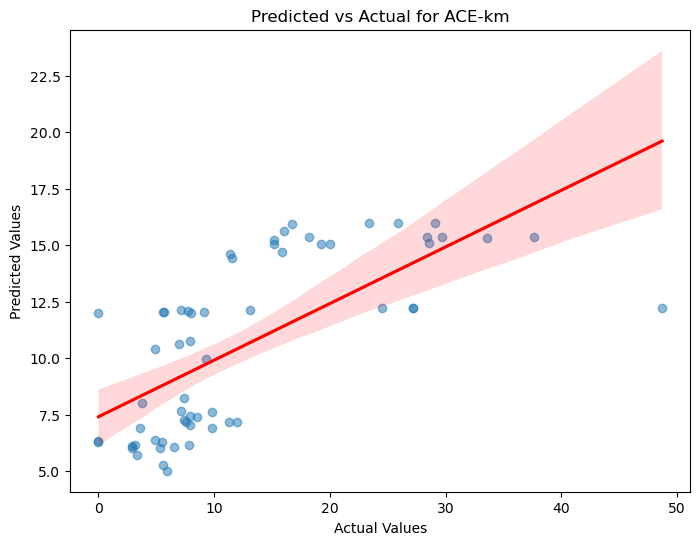

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# List of target columns
target_columns = [
    "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
    "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
    "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
    "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
    "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
    "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
    "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
    "Waste_SDW", "Biomass_F", "Biomass_G"
]

# Load dataset from DataFrame
def prepare_data(df, target_column):
    df = df.dropna()
    df = df.apply(pd.to_numeric, errors='coerce').fillna(0)
    X = df.drop(columns=target_columns).values.astype(np.float32)
    y = df[target_column].values.astype(np.float32)
    return X, y

# Define a custom dataset
class MicrobialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Transformer-based regression model
class TransformerRegressionModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super(TransformerRegressionModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

# Cross-validation function
def cross_validate(df, target_column, k_folds=5, epochs=50):
    X, y = prepare_data(df, target_column)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mse_scores, r2_scores = [], []
    all_actuals, all_predictions = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k_folds}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = MicrobialDataset(X_train, y_train)
        val_dataset = MicrobialDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_dim = X_train.shape[1]
        model = TransformerRegressionModel(input_dim=input_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        model.eval()
        val_preds, val_actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).cpu().numpy()
                val_preds.extend(predictions)
                val_actuals.extend(y_batch.cpu().numpy())
        
        mse = mean_squared_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)
        mse_scores.append(mse)
        r2_scores.append(r2)
        
        all_actuals.extend(val_actuals)
        all_predictions.extend(val_preds)
        print(f"Fold {fold+1}: MSE = {mse:.4f}, R^2 = {r2:.4f}")
    
    print(f"Final Cross-Validation Results: MSE = {np.mean(mse_scores):.4f}, R^2 = {np.mean(r2_scores):.4f}")
    
    # Scatter plot with line of best fit
    plt.figure(figsize=(8, 6))
    sns.regplot(x=all_actuals, y=all_predictions, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {target_column}")
    plt.show()

# Load dataset
df = pd.read_csv("Data/New_data.csv")

# Perform cross-validation for a target column
target_column = "ACE-km"
cross_validate(df, target_column)
